In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv(r"train.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [5]:
def drop_columns(df):
    df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)
drop_columns(data)


In [6]:
if (len(data[data.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


In [7]:
#Update datatypes
def update_datatype(df):
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
update_datatype(data)

In [8]:

data.replace('NaN', float(np.nan), regex=True,inplace=True)
data.isna().sum().sort_values(ascending = False)


Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weatherconditions               616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
dtype: int64

In [9]:
data['Weatherconditions']=data['Weatherconditions'].str.split(" ", expand=True)[1]
data['Time_taken(min)']=data['Time_taken(min)'].str.split(" ", expand=True)[1]

In [10]:
data['Time_taken(min)'] = data['Time_taken(min)'].astype(int)


In [11]:
def drop_missing_values(df):
    # Drop rows where any of the specified columns have missing values
    columns_to_check = ['Delivery_person_Age', 'Weatherconditions', 'City', 
                        'Festival', 'multiple_deliveries', 'Road_traffic_density', 
                        'Delivery_person_Ratings']
    df.dropna(subset=columns_to_check, inplace=True)

# Example usage
drop_missing_values(data)
print(data.isnull().sum())


Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64


In [12]:
import pandas as pd
import numpy as np

def calculate_time_diff(df):
    # Convert times to timedelta objects
    df['Time_Ordered'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_Picked'] = pd.to_timedelta(df['Time_Order_picked'])

    # Convert dates to datetime format
    df['Order_Date'] = pd.to_datetime(df['Order_Date'])

    # Calculate datetime for ordered and picked times
    # This approach ensures the date and time are combined correctly
    df['Time_Ordered_Formatted'] = df['Order_Date'] + df['Time_Ordered']
    df['Time_Order_Picked_Formatted'] = df['Order_Date'] + df['Time_Order_Picked']

    # Adjust for next day if time picked is earlier in the day than time ordered
    mask = df['Time_Order_Picked'] < df['Time_Ordered']
    df.loc[mask, 'Time_Order_Picked_Formatted'] += pd.Timedelta(days=1)

    # Calculate preparation time in minutes
    df['order_prepare_time'] = (df['Time_Order_Picked_Formatted'] - df['Time_Ordered_Formatted']).dt.total_seconds() / 60

    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)


calculate_time_diff(data)
data.head()


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,...,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Time_Ordered,Time_Order_Picked,Time_Ordered_Formatted,Time_Order_Picked_Formatted,order_prepare_time
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,...,motorcycle,0.0,No,Urban,24,0 days 11:30:00,0 days 11:45:00,2022-03-19 11:30:00,2022-03-19 11:45:00,15.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,...,scooter,1.0,No,Metropolitian,33,0 days 19:45:00,0 days 19:50:00,2022-03-25 19:45:00,2022-03-25 19:50:00,5.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,...,motorcycle,1.0,No,Urban,26,0 days 08:30:00,0 days 08:45:00,2022-03-19 08:30:00,2022-03-19 08:45:00,15.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,...,motorcycle,1.0,No,Metropolitian,21,0 days 18:00:00,0 days 18:10:00,2022-04-05 18:00:00,2022-04-05 18:10:00,10.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,...,scooter,1.0,No,Metropolitian,30,0 days 13:30:00,0 days 13:45:00,2022-03-26 13:30:00,2022-03-26 13:45:00,15.0


In [13]:
from geopy.distance import geodesic

In [14]:
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")

calculate_distance(data)
data.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,...,multiple_deliveries,Festival,City,Time_taken(min),Time_Ordered,Time_Order_Picked,Time_Ordered_Formatted,Time_Order_Picked_Formatted,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,...,0.0,No,Urban,24,0 days 11:30:00,0 days 11:45:00,2022-03-19 11:30:00,2022-03-19 11:45:00,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,...,1.0,No,Metropolitian,33,0 days 19:45:00,0 days 19:50:00,2022-03-25 19:45:00,2022-03-25 19:50:00,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,...,1.0,No,Urban,26,0 days 08:30:00,0 days 08:45:00,2022-03-19 08:30:00,2022-03-19 08:45:00,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,...,1.0,No,Metropolitian,21,0 days 18:00:00,0 days 18:10:00,2022-04-05 18:00:00,2022-04-05 18:10:00,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,...,1.0,No,Metropolitian,30,0 days 13:30:00,0 days 13:45:00,2022-03-26 13:30:00,2022-03-26 13:45:00,15.0,6


In [15]:
# Assume 'data' is your DataFrame and 'distance' is the column from which you want to remove outliers
Q1 = data['distance'].quantile(0.25)
Q3 = data['distance'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = data[(data['distance'] < lower_bound) | (data['distance'] > upper_bound)]
outlier_count = outliers.shape[0]
print(f"Number of outliers: {outlier_count}")

# Remove outliers
data_clean = data[(data['distance'] >= lower_bound) & (data['distance'] <= upper_bound)]

# Optionally, you can verify the new size of the data
print(f"Number of data points after outlier removal: {data_clean.shape[0]}")


Number of outliers: 146
Number of data points after outlier removal: 41222


In [16]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41222 entries, 0 to 45592
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   Delivery_person_Age          41222 non-null  float64        
 1   Delivery_person_Ratings      41222 non-null  float64        
 2   Restaurant_latitude          41222 non-null  float64        
 3   Restaurant_longitude         41222 non-null  float64        
 4   Delivery_location_latitude   41222 non-null  float64        
 5   Delivery_location_longitude  41222 non-null  float64        
 6   Order_Date                   41222 non-null  datetime64[ns] 
 7   Time_Orderd                  41222 non-null  object         
 8   Time_Order_picked            41222 non-null  object         
 9   Weatherconditions            41222 non-null  object         
 10  Road_traffic_density         41222 non-null  object         
 11  Vehicle_condition            4122

In [17]:
def drop_columns(df):
    df.drop(['Order_Date','Time_Orderd','Time_Ordered','Time_Order_Picked','Time_Order_picked','Time_Ordered_Formatted',
             'Time_Order_Picked_Formatted','Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'],axis=1,inplace=True)
drop_columns(data_clean)

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41222 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      41222 non-null  float64
 1   Delivery_person_Ratings  41222 non-null  float64
 2   Weatherconditions        41222 non-null  object 
 3   Road_traffic_density     41222 non-null  object 
 4   Vehicle_condition        41222 non-null  int64  
 5   Type_of_order            41222 non-null  object 
 6   Type_of_vehicle          41222 non-null  object 
 7   multiple_deliveries      41222 non-null  float64
 8   Festival                 41222 non-null  object 
 9   City                     41222 non-null  object 
 10  Time_taken(min)          41222 non-null  int32  
 11  order_prepare_time       41222 non-null  float64
 12  distance                 41222 non-null  int64  
dtypes: float64(4), int32(1), int64(2), object(6)
memory usage: 4.2+ MB


In [18]:
data = data_clean

In [19]:
def label_encoding(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(data)

In [20]:
X = data.drop('Time_taken(min)', axis=1)  # Features
y = data['Time_taken(min)']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
params = {
    'lambda': 2.313258228704945e-08,
    'alpha': 1.5981905166694308e-06, 
    'max_depth': 8, 
    'eta': 0.03577382014858771, 
    'subsample': 0.9863359918447062, 
    'colsample_bytree': 0.9981280426327332, 
    'min_child_weight': 1, 
    'learning_rate': 0.10817503787759337
}

In [26]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

best_model = xgb.XGBRegressor(**params)
best_model.fit(X_train, y_train)

train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

# Calculate MSE, RMSE, MAPE, and R-squared for the training set
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Calculate MSE, RMSE, MAPE, and R-squared for the testing set
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the results for both training and testing set
print("Training MSE: ", train_mse)
print("Training RMSE: ", train_rmse)
print("Training MAPE: ", train_mape)
print("Training R^2: ", train_r2)

print("Testing MSE: ", test_mse)
print("Testing RMSE: ", test_rmse)
print("Testing MAPE: ", test_mape)
print("Testing R^2: ", test_r2)

Training MSE:  9.664884357794852
Training RMSE:  3.1088397124642584
Training MAPE:  0.1079189073371287
Training R^2:  0.8892244890418564
Testing MSE:  13.668347155065227
Testing RMSE:  3.697072781954019
Testing MAPE:  0.1270317282279455
Testing R^2:  0.8426330259734598


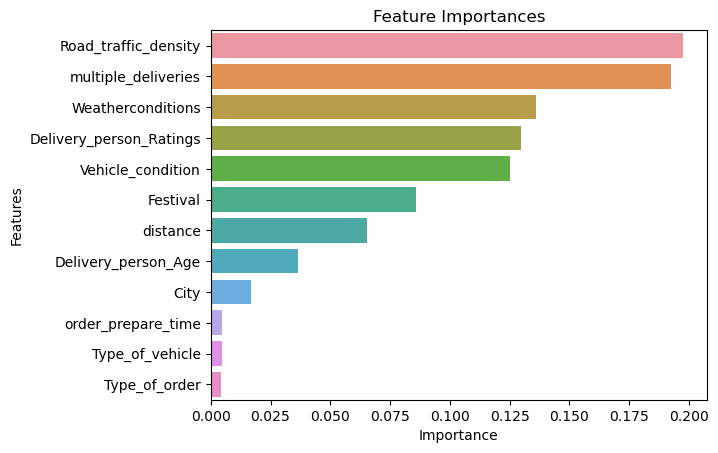

In [27]:
importances = best_model.feature_importances_

# Create a Series with feature names and importances
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

import seaborn as sns

sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


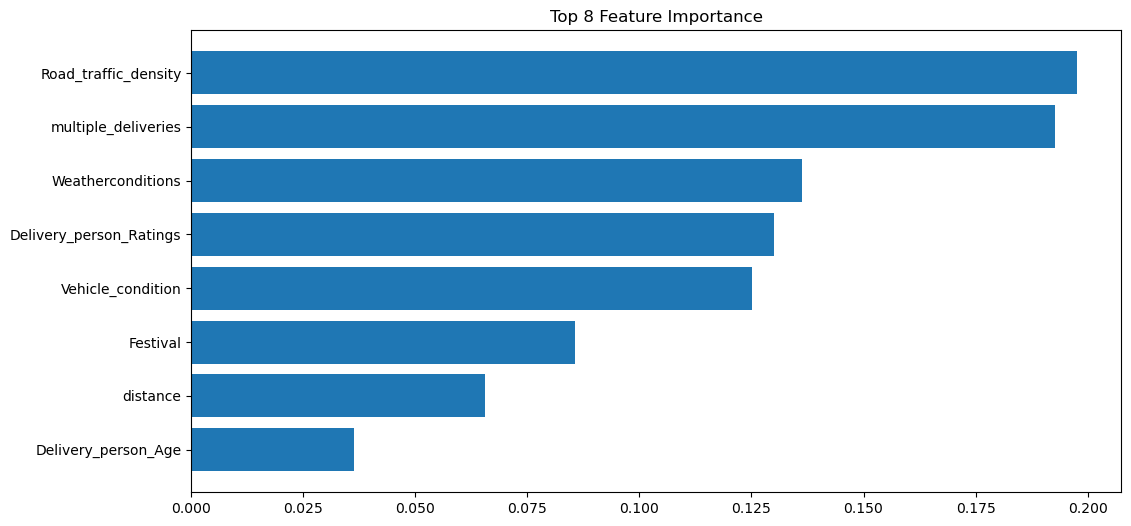

In [28]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-8:]  # Slice to get only the top 10 features

fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(np.array(X_test.columns)[sorted_idx])

ax.set_title('Top 8 Feature Importance')
plt.show()


In [30]:
threshold = 0.025 # Adjust this value based on your needs
important_features = X_train.columns[importances > threshold]
important_features

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions',
       'Road_traffic_density', 'Vehicle_condition', 'multiple_deliveries',
       'Festival', 'distance'],
      dtype='object')

In [32]:
threshold = 0.025 # Adjust this value based on your needs
important_features = X_train.columns[importances > threshold]

# Reduce X_train and X_test to important features only
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

best_params = params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_important, y_train)

XGBRegressor(alpha=1.5981905166694308e-06, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9981280426327332, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.03577382014858771, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2.313258228704945e-08,
             learning_rate=0.10817503787759337, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, ...)

In [33]:
train_predictions = best_model.predict(X_train_important)
test_predictions = best_model.predict(X_test_important)

# Calculate MSE, RMSE, MAPE, and R-squared for the training set
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Calculate MSE, RMSE, MAPE, and R-squared for the testing set
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the results for both training and testing set
print("Training MSE: ", train_mse)
print("Training RMSE: ", train_rmse)
print("Training MAPE: ", train_mape)
print("Training R^2: ", train_r2)

print("Testing MSE: ", test_mse)
print("Testing RMSE: ", test_rmse)
print("Testing MAPE: ", test_mape)
print("Testing R^2: ", test_r2)

Training MSE:  10.627750043556226
Training RMSE:  3.2600230127341474
Training MAPE:  0.11382029334957562
Training R^2:  0.8781884606347233
Testing MSE:  13.762304051208513
Testing RMSE:  3.7097579504879445
Testing MAPE:  0.12734489645080274
Testing R^2:  0.8415512775903339


In [34]:
X_train_important.info()


<class 'pandas.core.frame.DataFrame'>
Index: 32977 entries, 31414 to 17401
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Delivery_person_Age      32977 non-null  float64
 1   Delivery_person_Ratings  32977 non-null  float64
 2   Weatherconditions        32977 non-null  int32  
 3   Road_traffic_density     32977 non-null  int32  
 4   Vehicle_condition        32977 non-null  int64  
 5   multiple_deliveries      32977 non-null  float64
 6   Festival                 32977 non-null  int32  
 7   distance                 32977 non-null  int64  
dtypes: float64(3), int32(3), int64(2)
memory usage: 1.9 MB


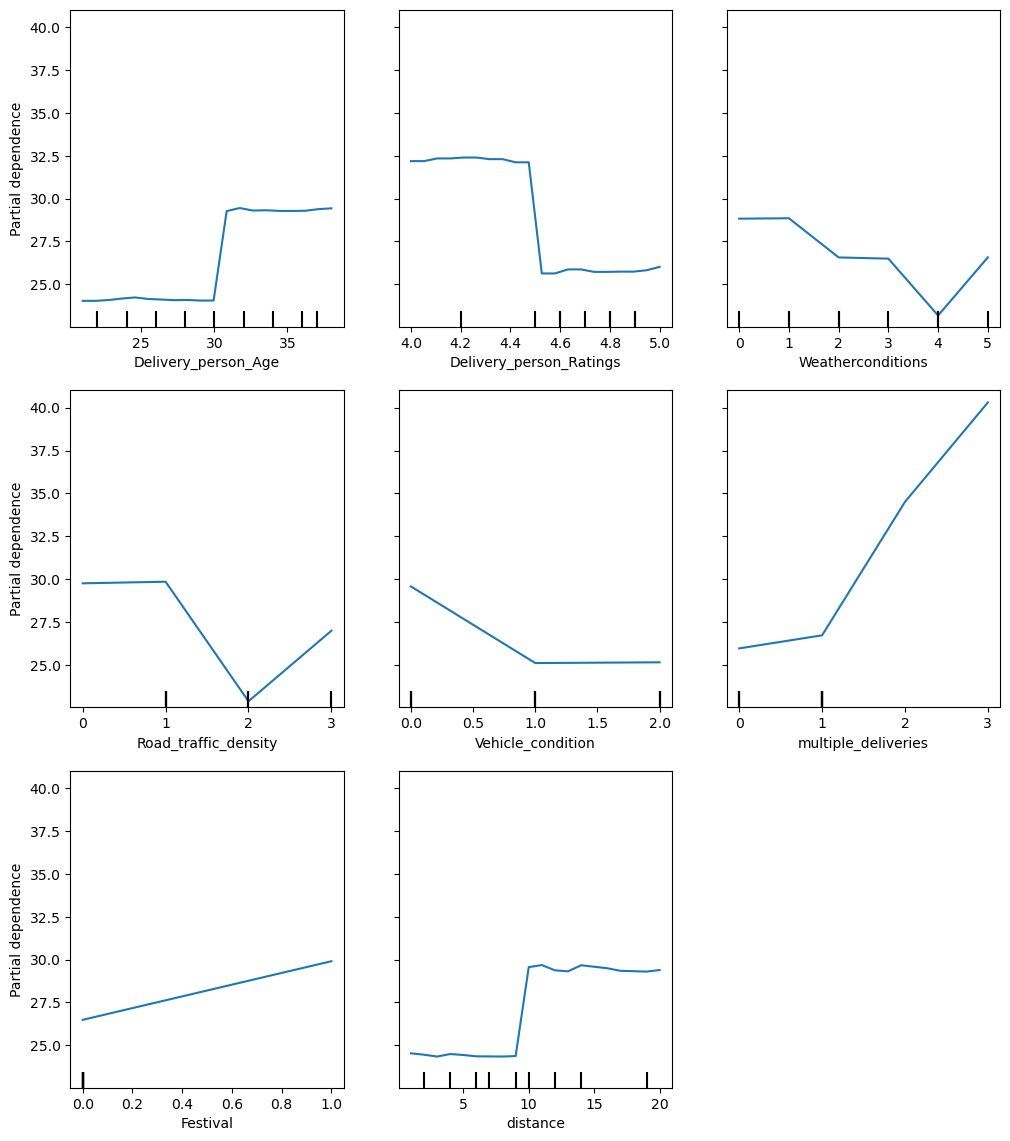

In [35]:
from sklearn.inspection import PartialDependenceDisplay

features = [0,1,2,3,4,5,6,7]  # Use integer index or feature names if available
fig, ax = plt.subplots(figsize=(12, 14))
display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_train_important,
    features,
    ax=ax,
    target=y_train,
    grid_resolution=20,  # Higher resolution gives smoother curves
)
plt.show()